In [1]:
from pulp import *
from ALB_instance_tools import *
from MDP_functions import *
import numpy as np
import pandas as pd

# MDP model
taken from Markov decision process for multi-manned mixed-model assembly lines with walking workers Hasemi-Petroodi et. al. 2022

In [2]:
instance_names = [
    "SALBP_benchmark/small data set_n=20/instance_n=20_1.alb",
    "SALBP_benchmark/small data set_n=20/instance_n=20_2.alb",
]
#instance_names = ['SALBP_benchmark/debugging_ds/instance_n=5_1.alb','SALBP_benchmark/debugging_ds/instance_n=5_2.alb' ]
test_instances = create_instance_pairs(instance_names)
# Parameters
WORKER_COST = 500
NO_EQUIPMENT = 2
NO_S = 3
NO_MODELS = 2
TAKT_TIME = 300  # cadence to respect
MAX_L = 4  # maximum number of workers at a station
# STATION_MODEL_PICTURES  = {}

S_E = [(s, e) for s in range(NO_S) for e in range(NO_EQUIPMENT)]
S_L = [(s, l) for s in range(NO_S) for l in range(1, MAX_L)]

NO_CONFIG = NO_MODELS**NO_S  # Number of possible line pictures

#test_instances[0] = eliminate_tasks(test_instances[0], (.6,0.8))
test_instances[0] = eliminate_tasks(test_instances[0], (0,0))
for i in range(NO_MODELS):
    test_instances[0][i]["cycle_time"] = TAKT_TIME
    test_instances[0][i]["c_em"] = WORKER_COST
    test_instances[0][i]["max_workers"] = MAX_L

all_tasks = list_all_tasks(test_instances[0])
seed = np.random.randint(0, 1000)
c_se, r_oe = generate_equipment(NO_EQUIPMENT, NO_S, all_tasks, seed = 550)
stations = list(range(NO_S))
models = list(range(NO_MODELS))
model_pairs = list(itertools.combinations(models, 2))
omega = []
enumerate_universe("", omega, NO_MODELS, NO_S)
actions = list(range(len(all_tasks) ** NO_S))
# equipment = list(range(NO_EQUIPMENT))
# workers = list(range(1, MAX_L+1))

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_35672/3684023632.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


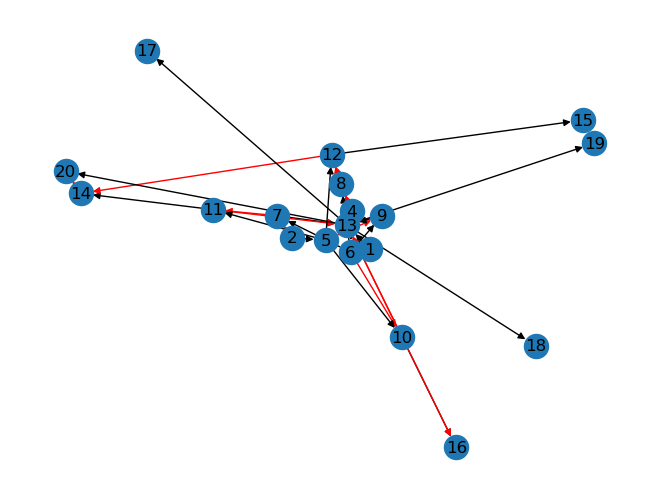

In [3]:
p_graph = nx.DiGraph()
p_graph.add_edges_from(test_instances[0][0]["precedence_relations"], color="r")
p_graph.add_edges_from(test_instances[0][1]["precedence_relations"], color="k")
colors = [p_graph[u][v]["color"] for u, v in p_graph.edges]
nx.draw(p_graph, edge_color=colors, with_labels=True)
plt.tight_layout()
# plt.savefig("precedence_graph.png", format="PNG" )

In [4]:
test_instances[0]

[{'num_tasks': 20,
  'cycle_time': 300,
  'order_strength': 0.268,
  'task_times': {'1': 142,
   '2': 34,
   '3': 140,
   '4': 214,
   '5': 121,
   '6': 279,
   '7': 50,
   '8': 282,
   '9': 129,
   '10': 175,
   '11': 97,
   '12': 132,
   '13': 107,
   '14': 132,
   '15': 69,
   '16': 169,
   '17': 73,
   '18': 231,
   '19': 120,
   '20': 186},
  'precedence_relations': [('1', '6'),
   ('6', '10'),
   ('2', '7'),
   ('7', '11'),
   ('4', '8'),
   ('8', '12'),
   ('5', '9'),
   ('10', '13'),
   ('11', '13'),
   ('12', '14'),
   ('12', '15'),
   ('13', '16'),
   ('13', '17'),
   ('13', '18'),
   ('14', '20'),
   ('15', '19')],
  'model_no': 0,
  'c_em': 500,
  'max_workers': 4},
 {'num_tasks': 20,
  'cycle_time': 300,
  'order_strength': 0.3,
  'task_times': {'1': 58,
   '2': 224,
   '3': 20,
   '4': 150,
   '5': 410,
   '6': 117,
   '7': 262,
   '8': 94,
   '9': 213,
   '10': 118,
   '11': 191,
   '12': 74,
   '13': 60,
   '14': 117,
   '15': 124,
   '16': 103,
   '17': 178,
   '18': 1

## MDP State
### State variables

In the paper we have:
F_isd -- Equal to 1 when model i is located at station s in state d, 0 otherwise

P_osd -- equal to 1 if model 1 if task o has been already executed for the the model in station s when the sytem passed to state d, 0 otherwise


R_osa -- equal to 1 if action a performs task o on the model in station s

However in the implementation we use the dictionaries D to contain the information in F_isd, P_osd, and A to contain the information in F_isd, P_osd, R_osa

### Transistion variables
Tr_a_d_dprime -- probability to transistion from state d to state d' with action a

Here we created a function that given a action, state, and next state will tell you the probability of the current state reaching the next state. (Way more space efficient than a matrix)

### Other parameters
q_as -- number of workers required in station s for action a
(This is also included in the dictionary A)

## MDP MILP
whew, finally

### Decision Variables

W_se -- 1 if equipment e is chosen for station s, 0 otherwise

X_ad -- probability of taking action a in state d

### Other variables
y_asoi -- 1 if task o is at station s for model i during action a (This is covered by the Action dictionary)


In [5]:
#TODO fix this so it works with  0 workers at a station
def make_dynamic_MILP(entry_probs = (0.75, 0.25)):

    # Markov Decision Process state/action information
    no_line_pictures = len(omega)
    feasible_partitions = get_feasible_partitions(
    models, NO_S, all_tasks, test_instances[0]
        )
    model_histories = create_model_histories(feasible_partitions, models, NO_S)
    D = create_D(omega, model_histories, NO_S)
    
    A = create_A(D, model_histories, test_instances[0], all_tasks, TAKT_TIME, MAX_L, NO_S)
    #print("model histories", model_histories)
    # for d in D:
    #     print(d)
    for a in A:
        print(a)
    print(
        "length of D: ", 
        len(D),
        "length of A: ",
        len(A),
        ", length of omega:",
        len(omega),
    )

        # Decision Variables
    X_ad = LpVariable.dicts(
        "X_ad",
        (action["action_index"] for action in A),
        lowBound=0,
        upBound=1,
        cat=LpContinuous,
    )
    W_se = LpVariable.dicts("W_se", (S_E), lowBound=0, upBound=1, cat=LpBinary)
    
    prob = LpProblem("MDP", LpMinimize)
    prob += (
        lpSum(
            [
                X_ad[action["action_index"]] * WORKER_COST * action["total_workers"]
                for action in A
            ]
            + [W_se[s, e] * c_se[s, e] for s, e in S_E]
        ),
        "Total Cost",
    )


    for ind, d_prime in enumerate(D):
        d_prime_indices = [
            action["action_index"]
            for action in A
            if action["state_index"] == d_prime["index"]
        ]
        # constraint 3
        prob += (
            lpSum(
                [
                    X_ad[action["action_index"]]
                    * state_transistion_probability(
                        action, D[int(action["state_index"])], d_prime, NO_S, entry_probs=entry_probs
                    )
                    for action in A
                ]
            )
            == lpSum([X_ad[action] for action in d_prime_indices]),
            f"State_{d_prime['index']}_probability",
        )
    # constraint 4
    prob += (
        lpSum([X_ad[action["action_index"]] for action in A]) == 1,
        "Sum of probabilities",
    )
    for station in range(NO_S):
                    for a in A:
                        for task in a[f'action_at_{station}']:
                            # constraint 5
                            prob += (
                                X_ad[a["action_index"]]
                                <= lpSum(
                                    [
                                        r_oe[all_tasks.index(task)][equipment] * W_se[station, equipment]
                                        for equipment in range(NO_EQUIPMENT)
                                    ]
                                ),
                                f"equipment_for_o_{task}_s_{station}_a_{a['action_index']}",
                            )
    print("number of constraints", len(prob.constraints))
    print("number of variables", len(prob.variables()))
    return prob

# prob = make_dynamic_MILP()
# solver=XPRESS_PY(export="model.lp")
# #solver=GUROBI_CMD()
# prob.solve(solver=solver)

# for v in prob.variables():
#     if v.varValue > 0:
#         print(v.name, v.varValue)

In [6]:
list_solvers(onlyAvailable=True)

No parameters matching '_test' found


['CPLEX_PY', 'GUROBI', 'GUROBI_CMD', 'XPRESS_PY', 'COIN_CMD']

# Fixed Task assignment MILP, Model Dependent Task Assignment MILP


Taken from Model-dependent task assignment in multi-manned mixed-model assembly lines with walking workers Hashemi-Petroodi 2022. He we modified the equipment cost constraints so instead of having to pay for a piece of equipment for each worker, we pay for a piece of equipment for the station.
## Decision Variables
NOTICE-- here I am using w as omega

Y -- # workers \
u_se -- # of pieces of equipment e at station s \
b_wsl --  1 if there are l workers in station s for picture w, 0 otherwise\
b_woisl -- 1 if there are l workers performing task o on model i at station s for picture w, 0 otherwise\
x_soi -- 1 if task o is performed on model i at station s, 0 otherwise

In [7]:
def fixed_assignment_problem(model_dependent = False):
    #variables
    workers = list(range(0, MAX_L+1))
    equipment = list(range(NO_EQUIPMENT))
    y = LpVariable("Y", lowBound=0, cat=LpInteger)
    u_se = LpVariable.dicts('u_se',(stations,equipment), lowBound=0, cat= LpBinary)
    b_wsl = LpVariable.dicts('b_wsl', (range(NO_CONFIG), stations, workers), lowBound=0, upBound=1, cat=LpBinary )
    b_woisl = LpVariable.dicts('b_woisl',(range(NO_CONFIG), all_tasks, models, stations, workers),lowBound=0, upBound=1, cat=LpBinary)
    x_soi = LpVariable.dicts('x_soi', (stations, all_tasks, models), lowBound=0, cat=LpBinary)
    if model_dependent:
        prob = pulp.LpProblem("MALBP-W-Model_Dependent", LpMinimize)
    else:
         prob = pulp.LpProblem("MALBP-W_fixed", LpMinimize)

    #Calculate the task times for each task with a certain number of workers
    for test_instance in test_instances:
        for model in test_instance:
            model[f'task_times_l'] = {}
            for i in workers:
                model[f'task_times_l'][i] = linear_reduction(model['task_times'], i)
    #Define the problem, add an objective function and the constraints
    prob += ( lpSum([WORKER_COST * y] + [c_se[s][e]* u_se[s][e] for (s,e) in S_E]), 'TOTAL_COST')
    prob = add_constraints_for_fixed_assignment(prob, b_wsl, b_woisl, x_soi, u_se, workers,equipment, y, model_dependent)
    return prob

def add_constraints_for_fixed_assignment(prob, b_wsl, b_woisl, x_soi, u_se, workers,equipment, y, model_dependent = False):
    for w_in, w in enumerate(omega):
        #Constraint 2 in MILP_fix
        prob += pulp.lpSum([l * b_wsl[w_in][s][l] for s in stations for l in workers])<= y, ("tot Workers Pic" + str(w) ) 
        for s_in, s in enumerate(stations):
            #Constraint 3 in MILP_fix
            prob += pulp.lpSum([b_wsl[w_in][s_in][l] for l in workers])==1, (f'workers_at_station_{s}_pic_{w}') 
            model_at_s = omega[w_in][s_in]
            tasks = test_instances[0][int(model_at_s)]['task_times_l']
            #constraint 9 
            prob += pulp.lpSum([tasks[l][task]*b_woisl[w_in][task][int(model_at_s)][s_in][l] for l in workers for task in tasks[l].keys() ]) <= TAKT_TIME, (f'C for picture {w}, station {s}')
    
            for l in workers:
                for i in models:
                    for o in test_instances[0][i]['task_times']:
                        #const. 10
                        prob +=  b_woisl[w_in][o][i][s][l] <= pulp.lpSum([r_oe[int(o)-1][e] * u_se[s_in][e] for e in equipment]), (f' e that can cover woisl {w} {o} {i} {s} {l} ')
        
    for i in models:
        for task in test_instances[0][i]['task_times']:
                 #constraint 4
                prob+= pulp.lpSum([x_soi[s][task][i] for s in stations]) == 1, (f'task_{task}_assignment_model_{i}')
        for (pred, suc) in test_instances[0][i]['precedence_relations']:
            #constraint 11
            prob += pulp.lpSum([ (s+1)  * x_soi[s][pred][i] for s in stations]) <=  pulp.lpSum([ (s+1)  * x_soi[s][suc][i] for s in stations]), (f'task{pred} before task{suc} for model{i}') 

    if not model_dependent:  
        for m1, m2 in model_pairs:
            shared_tasks = get_task_intersection(test_instances[0], m1, m2)
            for task in shared_tasks:
                for s in stations:
                    #constraint 5
                    prob += x_soi[s][task][m1] == x_soi[s][task][m2], (f'task {task} for models {m1, m2} at s {s}')
    
    for w_in, w in enumerate(omega):
        for l in workers:
            for i in models:
                for o in test_instances[0][i]['task_times']:
                    for s_in, station_picture in enumerate(w):
                        #if str(i) == station_picture:
                            print(w)
                            print('s_in', s_in, 'o', o, 'i', i, 'l', l, 'w_in', w_in)
                            #It  seems that for fixed model assignment we are forcing the same number of workers to be assigned to each station
                            prob += b_woisl[w_in][o][i][s_in][l] <= x_soi[s_in][o][i], (f'{l} workers task{o} s{s_in} pic {w_in} mod {i} x_soi on') #constraint 6
                            prob += b_woisl[w_in][o][i][s_in][l] <= b_wsl[w_in][s_in][l],(f'{l} workers task{o} s{s_in} pic {w_in} mod {i} b_wsl on') #constraint 7
                            prob += b_woisl[w_in][o][i][s_in][l] >= b_wsl[w_in][s_in][l] + x_soi[s_in][o][i] - 1, (f'{l} workers task {o} s{s_in} pic {w_in} mod {i} b_wsl x_soi coord') #constraint 8
    return prob

fix_prob = fixed_assignment_problem()
model_dependent_prob =fixed_assignment_problem(model_dependent=True)
fix_prob

['0', '0', '0']
s_in 0 o 1 i 0 l 0 w_in 0
['0', '0', '0']
s_in 1 o 1 i 0 l 0 w_in 0
['0', '0', '0']
s_in 2 o 1 i 0 l 0 w_in 0
['0', '0', '0']
s_in 0 o 2 i 0 l 0 w_in 0
['0', '0', '0']
s_in 1 o 2 i 0 l 0 w_in 0
['0', '0', '0']
s_in 2 o 2 i 0 l 0 w_in 0
['0', '0', '0']
s_in 0 o 3 i 0 l 0 w_in 0
['0', '0', '0']
s_in 1 o 3 i 0 l 0 w_in 0
['0', '0', '0']
s_in 2 o 3 i 0 l 0 w_in 0
['0', '0', '0']
s_in 0 o 4 i 0 l 0 w_in 0
['0', '0', '0']
s_in 1 o 4 i 0 l 0 w_in 0
['0', '0', '0']
s_in 2 o 4 i 0 l 0 w_in 0
['0', '0', '0']
s_in 0 o 5 i 0 l 0 w_in 0
['0', '0', '0']
s_in 1 o 5 i 0 l 0 w_in 0
['0', '0', '0']
s_in 2 o 5 i 0 l 0 w_in 0
['0', '0', '0']
s_in 0 o 6 i 0 l 0 w_in 0
['0', '0', '0']
s_in 1 o 6 i 0 l 0 w_in 0
['0', '0', '0']
s_in 2 o 6 i 0 l 0 w_in 0
['0', '0', '0']
s_in 0 o 7 i 0 l 0 w_in 0
['0', '0', '0']
s_in 1 o 7 i 0 l 0 w_in 0
['0', '0', '0']
s_in 2 o 7 i 0 l 0 w_in 0
['0', '0', '0']
s_in 0 o 8 i 0 l 0 w_in 0
['0', '0', '0']
s_in 1 o 8 i 0 l 0 w_in 0
['0', '0', '0']
s_in 2 o 8 i 0 l 0

MALBP-W_fixed:
MINIMIZE
500*Y + 295*u_se_0_0 + 164*u_se_0_1 + 258*u_se_1_0 + 281*u_se_1_1 + 194*u_se_2_0 + 295*u_se_2_1 + 0
SUBJECT TO
tot_Workers_Pic_'0',_'0',_'0'_: - Y + b_wsl_0_0_1 + 2 b_wsl_0_0_2
 + 3 b_wsl_0_0_3 + 4 b_wsl_0_0_4 + b_wsl_0_1_1 + 2 b_wsl_0_1_2 + 3 b_wsl_0_1_3
 + 4 b_wsl_0_1_4 + b_wsl_0_2_1 + 2 b_wsl_0_2_2 + 3 b_wsl_0_2_3 + 4 b_wsl_0_2_4
 <= 0

workers_at_station_0_pic__'0',_'0',_'0'_: b_wsl_0_0_0 + b_wsl_0_0_1
 + b_wsl_0_0_2 + b_wsl_0_0_3 + b_wsl_0_0_4 = 1

C_for_picture__'0',_'0',_'0'_,_station_0: 175 b_woisl_0_10_0_0_0
 + 175 b_woisl_0_10_0_0_1 + 87.5 b_woisl_0_10_0_0_2
 + 58.3333333333 b_woisl_0_10_0_0_3 + 43.75 b_woisl_0_10_0_0_4
 + 97 b_woisl_0_11_0_0_0 + 97 b_woisl_0_11_0_0_1 + 48.5 b_woisl_0_11_0_0_2
 + 32.3333333333 b_woisl_0_11_0_0_3 + 24.25 b_woisl_0_11_0_0_4
 + 132 b_woisl_0_12_0_0_0 + 132 b_woisl_0_12_0_0_1 + 66 b_woisl_0_12_0_0_2
 + 44 b_woisl_0_12_0_0_3 + 33 b_woisl_0_12_0_0_4 + 107 b_woisl_0_13_0_0_0
 + 107 b_woisl_0_13_0_0_1 + 53.5 b_woisl_0_13_0_0_2

In [8]:
#path_to_cplex = '/Applications/CPLEX_Studio_Community2211/cplex/bin/x86-64_osx/cplex'
# solver = CPLEX_CMD(path=path_to_cplex, msg=True)
#solver = getSolver('CPLEX_PY')
#prob.numVariables()
fix_prob.solve(solver=GUROBI_CMD())

Set parameter LogFile to value "gurobi.log"
Using license file /Users/letshopethisworks2/gurobi.lic

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])
Copyright (c) 2023, Gurobi Optimization, LLC

Read LP format model from file /var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/f121b38171d44bc48aa09cd6b7ee9378-pulp.lp
Reading time = 0.03 seconds
TOTAL_COST: 19391 rows, 5047 columns, 51074 nonzeros

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19391 rows, 5047 columns and 51074 nonzeros
Model fingerprint: 0xc7a74b44
Variable types: 0 continuous, 5047 integer (5046 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [2e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 9144 rows and 2415 columns
Presolve time: 1.00s
Presolved: 10247 rows, 2632 columns, 25879 nonzeros
Variable types: 0 continuous, 2632 integer (2631 binary)

1

In [13]:
fix_prob.status

1

In [9]:
def generate_task_assignments_df(pulp_prob):
    '''Shows task assignments for fixed and model dependent task assignment'''
    task_assignments = []
    labor_assignments = []
    for v in pulp_prob.variables():
        if v.varValue > 0:
            print(v.name, v.varValue)
            if 'x_soi' in v.name:
                assignment = {'station': v.name.split('_')[2], 'task': v.name.split('_')[3], 'model': v.name.split('_')[4], 'task_times': int(test_instances[0][int(v.name.split('_')[4])]['task_times'][v.name.split('_')[3]])}
                task_assignments.append(assignment)
            elif 'b_wsl' in v.name:
                labor = {'model':omega[int(v.name.split('_')[2])][int(v.name.split('_')[3])], 'station': v.name.split('_')[3],  'workers': int(v.name.split('_')[4]) }
                labor_assignments.append(labor)

    #turns task_assignments into a dataframe
    task_assignments_df = pd.DataFrame(task_assignments)
    labor_assignments_df = pd.DataFrame(labor_assignments)
    #concatenates the 'task' column in task_assignments_df if the 'station' and 'model' columns are the same
    task_assignments_df = task_assignments_df.groupby(['station', 'model'])['task', 'task_times'].agg({'task':lambda x: ','.join(x.astype(str)), 'task_times': sum }).reset_index()
    #concatenates the 'task' column in labor_assignments_df if the 'station' and 'model' columns are the same
    labor_assignments_df = labor_assignments_df.groupby(['model','station'])[ 'workers'].apply( max).reset_index()
    #print(labor_assignments_df)
    #concatenates the 'workers' column in labor_assignments_df  to the task_assignments_df if the 'station' and 'model' columns are the same
    task_assignments_df = pd.merge(task_assignments_df, labor_assignments_df, on=['station', 'model'])
    return task_assignments_df
fixed_task_assignments_df = generate_task_assignments_df(fix_prob)
fixed_task_assignments_df

Y 10.0
b_woisl_0_10_0_0_4 1.0
b_woisl_0_10_1_0_4 1.0
b_woisl_0_11_0_1_4 1.0
b_woisl_0_11_1_1_4 1.0
b_woisl_0_12_0_1_4 1.0
b_woisl_0_12_1_1_4 1.0
b_woisl_0_13_0_1_4 1.0
b_woisl_0_13_1_1_4 1.0
b_woisl_0_14_0_2_2 1.0
b_woisl_0_14_1_2_2 1.0
b_woisl_0_15_0_2_2 1.0
b_woisl_0_15_1_2_2 1.0
b_woisl_0_16_0_1_4 1.0
b_woisl_0_16_1_1_4 1.0
b_woisl_0_17_0_2_2 1.0
b_woisl_0_17_1_2_2 1.0
b_woisl_0_18_0_1_4 1.0
b_woisl_0_18_1_1_4 1.0
b_woisl_0_19_0_2_2 1.0
b_woisl_0_19_1_2_2 1.0
b_woisl_0_1_0_0_4 1.0
b_woisl_0_1_1_0_4 1.0
b_woisl_0_20_0_2_2 1.0
b_woisl_0_20_1_2_2 1.0
b_woisl_0_2_0_0_4 1.0
b_woisl_0_2_1_0_4 1.0
b_woisl_0_3_0_0_4 1.0
b_woisl_0_3_1_0_4 1.0
b_woisl_0_4_0_0_4 1.0
b_woisl_0_4_1_0_4 1.0
b_woisl_0_5_0_0_4 1.0
b_woisl_0_5_1_0_4 1.0
b_woisl_0_6_0_0_4 1.0
b_woisl_0_6_1_0_4 1.0
b_woisl_0_7_0_1_4 1.0
b_woisl_0_7_1_1_4 1.0
b_woisl_0_8_0_1_4 1.0
b_woisl_0_8_1_1_4 1.0
b_woisl_0_9_0_1_4 1.0
b_woisl_0_9_1_1_4 1.0
b_woisl_1_10_0_0_4 1.0
b_woisl_1_10_1_0_4 1.0
b_woisl_1_11_0_1_4 1.0
b_woisl_1_11_1_1_4 1.0

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_35672/2890756343.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  task_assignments_df = task_assignments_df.groupby(['station', 'model'])['task', 'task_times'].agg({'task':lambda x: ','.join(x.astype(str)), 'task_times': sum }).reset_index()


,station,model,task,task_times,workers
0,0,0,"10,1,2,3,4,5,6",1105,4
1,0,1,"10,1,2,3,4,5,6",1097,4
2,1,0,"11,12,13,16,18,7,8,9",1197,4
3,1,1,"11,12,13,16,18,7,8,9",1185,4
4,2,0,"14,15,17,19,20",580,2
5,2,1,"14,15,17,19,20",579,2


In [10]:
omega[1]

['0', '0', '1']

In [11]:
varsdict = {}
for v in fix_prob.variables():
    if v.varValue > 0:
        print(v.name, v.varValue)

Y 10.0
b_woisl_0_10_0_0_4 1.0
b_woisl_0_10_1_0_4 1.0
b_woisl_0_11_0_1_4 1.0
b_woisl_0_11_1_1_4 1.0
b_woisl_0_12_0_1_4 1.0
b_woisl_0_12_1_1_4 1.0
b_woisl_0_13_0_1_4 1.0
b_woisl_0_13_1_1_4 1.0
b_woisl_0_14_0_2_2 1.0
b_woisl_0_14_1_2_2 1.0
b_woisl_0_15_0_2_2 1.0
b_woisl_0_15_1_2_2 1.0
b_woisl_0_16_0_1_4 1.0
b_woisl_0_16_1_1_4 1.0
b_woisl_0_17_0_2_2 1.0
b_woisl_0_17_1_2_2 1.0
b_woisl_0_18_0_1_4 1.0
b_woisl_0_18_1_1_4 1.0
b_woisl_0_19_0_2_2 1.0
b_woisl_0_19_1_2_2 1.0
b_woisl_0_1_0_0_4 1.0
b_woisl_0_1_1_0_4 1.0
b_woisl_0_20_0_2_2 1.0
b_woisl_0_20_1_2_2 1.0
b_woisl_0_2_0_0_4 1.0
b_woisl_0_2_1_0_4 1.0
b_woisl_0_3_0_0_4 1.0
b_woisl_0_3_1_0_4 1.0
b_woisl_0_4_0_0_4 1.0
b_woisl_0_4_1_0_4 1.0
b_woisl_0_5_0_0_4 1.0
b_woisl_0_5_1_0_4 1.0
b_woisl_0_6_0_0_4 1.0
b_woisl_0_6_1_0_4 1.0
b_woisl_0_7_0_1_4 1.0
b_woisl_0_7_1_1_4 1.0
b_woisl_0_8_0_1_4 1.0
b_woisl_0_8_1_1_4 1.0
b_woisl_0_9_0_1_4 1.0
b_woisl_0_9_1_1_4 1.0
b_woisl_1_10_0_0_4 1.0
b_woisl_1_10_1_0_4 1.0
b_woisl_1_11_0_1_4 1.0
b_woisl_1_11_1_1_4 1.0

In [12]:
model_dependent_prob.solve(solver=GUROBI_CMD())

Set parameter LogFile to value "gurobi.log"
Using license file /Users/letshopethisworks2/gurobi.lic

Gurobi Optimizer version 10.0.2 build v10.0.2rc0 (mac64[rosetta2])
Copyright (c) 2023, Gurobi Optimization, LLC

Read LP format model from file /var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/fe6b9850e0674dcb93c5821323854610-pulp.lp
Reading time = 0.03 seconds
TOTAL_COST: 19331 rows, 5047 columns, 50954 nonzeros

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 19331 rows, 5047 columns and 50954 nonzeros
Model fingerprint: 0xaa41a5e3
Variable types: 0 continuous, 5047 integer (5046 binary)
Coefficient statistics:
  Matrix range     [1e+00, 4e+02]
  Objective range  [2e+02, 5e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+02]
Presolve removed 3084 rows and 756 columns
Presolve time: 0.61s
Presolved: 16247 rows, 4291 columns, 41507 nonzeros
Variable types: 0 continuous, 4291 integer (4290 binary)


KeyboardInterrupt: 

In [ ]:
task_assignments_df = generate_task_assignments_df(model_dependent_prob)
task_assignments_df

Y 2.0
b_woisl_0_1_0_0_0 1.0
b_woisl_0_1_1_0_0 1.0
b_woisl_0_2_0_2_2 1.0
b_woisl_0_2_1_0_0 1.0
b_woisl_0_3_0_2_2 1.0
b_woisl_0_3_1_2_2 1.0
b_woisl_0_4_0_2_2 1.0
b_woisl_0_4_1_2_2 1.0
b_woisl_0_5_0_2_2 1.0
b_woisl_0_5_1_2_2 1.0
b_woisl_1_1_0_0_0 1.0
b_woisl_1_1_1_0_0 1.0
b_woisl_1_2_0_2_2 1.0
b_woisl_1_2_1_0_0 1.0
b_woisl_1_3_0_2_2 1.0
b_woisl_1_3_1_2_2 1.0
b_woisl_1_4_0_2_2 1.0
b_woisl_1_4_1_2_2 1.0
b_woisl_1_5_0_2_2 1.0
b_woisl_1_5_1_2_2 1.0
b_woisl_2_1_0_0_0 1.0
b_woisl_2_1_1_0_0 1.0
b_woisl_2_2_0_2_2 1.0
b_woisl_2_2_1_0_0 1.0
b_woisl_2_3_0_2_2 1.0
b_woisl_2_3_1_2_2 1.0
b_woisl_2_4_0_2_2 1.0
b_woisl_2_4_1_2_2 1.0
b_woisl_2_5_0_2_2 1.0
b_woisl_2_5_1_2_2 1.0
b_woisl_3_1_0_0_0 1.0
b_woisl_3_1_1_0_0 1.0
b_woisl_3_2_0_2_2 1.0
b_woisl_3_2_1_0_0 1.0
b_woisl_3_3_0_2_2 1.0
b_woisl_3_3_1_2_2 1.0
b_woisl_3_4_0_2_2 1.0
b_woisl_3_4_1_2_2 1.0
b_woisl_3_5_0_2_2 1.0
b_woisl_3_5_1_2_2 1.0
b_woisl_4_1_0_0_0 1.0
b_woisl_4_1_1_0_0 1.0
b_woisl_4_2_0_2_2 1.0
b_woisl_4_2_1_0_0 1.0
b_woisl_4_3_0_2_2 1.0
b_wo

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_13507/2890756343.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  task_assignments_df = task_assignments_df.groupby(['station', 'model'])['task', 'task_times'].agg({'task':lambda x: ','.join(x.astype(str)), 'task_times': sum }).reset_index()


,station,model,task,task_times,workers
0,0,0,1,142,0
1,0,1,"1,2",282,0
2,2,0,"2,3,4,5",509,2
3,2,1,"3,4,5",580,2


In [ ]:
#print("Dynamic obj value", value(prob.objective), "fixed obj value", value(fix_prob.objective), "model dependent obj value", value(model_dependent_prob.objective))
print("fixed obj value", value(fix_prob.objective), "model dependent obj value", value(model_dependent_prob.objective))

#print('random seed', seed)

fixed obj value 1358.0 model dependent obj value 1358.0


#TODO Try to force fixed solution in dynamic and see the resulting cost


## Constructive Heuristic

Constructive heuristic from "Model-dependent task assignment in multi-manned mixed-model assembly lines with walking workers" (Hashemi-Petroodi et al. 2022)

In [ ]:
#Tasks selection methods
def longest_processing_time(model, candidate_list, **kwargs):
    max_task_time = 0
    for candidate in candidate_list:
        if model['task_times'][candidate] > max_task_time:
            max_task_time = model['task_times'][candidate]
            selected_task = candidate
    return selected_task


#Methods for the construction heurisitc

def calculate_takt_time(model, NO_S, TAKT_TIME):
    """
    Calculate the takt time for the model dependent model
    """
    total_task_time = sum(model['task_times'].values())
    new_takt_time = max(total_task_time/NO_S, TAKT_TIME)
    return new_takt_time

def model_task_assignment(model, all_tasks, NO_S, TAKT_TIME, selection_method, **kwargs):
    '''This function assigns the tasks of a model '''
    x_so = np.zeros((NO_S,len(all_tasks)))
    new_takt_time = calculate_takt_time( model, NO_S, TAKT_TIME)
    prec_matrix = construct_precedence_matrix(model)
    number_of_predecessor = np.sum(prec_matrix, axis=0)
    for station in range(NO_S):
        s_total_assingments = 0
        while s_total_assingments < new_takt_time and np.any(number_of_predecessor != -1):
            candidate_list = []
            for task in model['task_times']:
                task_in = int(task)-1
                if number_of_predecessor[task_in] == 0:
                    candidate_list.append(task)
            selected_task = selection_method(model, candidate_list,  **kwargs)
            selected_task_in = int(selected_task)-1
            x_so[station, selected_task_in] = 1
            s_total_assingments += model['task_times'][selected_task]
            number_of_predecessor -= prec_matrix[selected_task_in]
            number_of_predecessor[selected_task_in] = -1
        #If all the elements in number of predecessor are -1, then all tasks are assigned
        if np.all(number_of_predecessor == -1):
            break
    return x_so

def constructive_heurisitc(instance, NO_S, TAKT_TIME, selection_method):
    """
    Constructive heuristic for the model dependent model
    """
    print('instance', instance)
    all_tasks = list_all_tasks(instance)
    assignments = []
    #heuristic asssigns tasks for each model in instance
    for model in instance:
        x_so = model_task_assignment( model, all_tasks, NO_S, TAKT_TIME, selection_method)
        assignments.append(x_so)
    #combines assignments list into a single numpy array, where eac
    x_soi = np.stack(assignments, axis=-1)
    return x_soi

heur_x_soi =  constructive_heurisitc(test_instances[0], NO_S, TAKT_TIME, longest_processing_time)
#heur_x_soi
# model_task_assignment(test_instances[0][1], list_all_tasks(test_instances[0]), NO_S, TAKT_TIME, longest_processing_time)

instance [{'num_tasks': 20, 'cycle_time': 300, 'order_strength': 0.268, 'task_times': {'1': 142, '2': 34, '3': 140, '4': 214, '5': 121, '6': 279, '7': 50, '8': 282, '9': 129, '10': 175, '11': 97, '12': 132, '13': 107, '14': 132, '15': 69, '16': 169, '17': 73, '18': 231, '19': 120, '20': 186}, 'precedence_relations': [('1', '6'), ('6', '10'), ('2', '7'), ('7', '11'), ('4', '8'), ('8', '12'), ('5', '9'), ('10', '13'), ('11', '13'), ('12', '14'), ('12', '15'), ('13', '16'), ('13', '17'), ('13', '18'), ('14', '20'), ('15', '19')], 'model_no': 0, 'c_em': 500, 'max_workers': 4, 'task_times_l': {0: {'1': 142, '2': 34, '3': 140, '4': 214, '5': 121, '6': 279, '7': 50, '8': 282, '9': 129, '10': 175, '11': 97, '12': 132, '13': 107, '14': 132, '15': 69, '16': 169, '17': 73, '18': 231, '19': 120, '20': 186}, 1: {'1': 142.0, '2': 34.0, '3': 140.0, '4': 214.0, '5': 121.0, '6': 279.0, '7': 50.0, '8': 282.0, '9': 129.0, '10': 175.0, '11': 97.0, '12': 132.0, '13': 107.0, '14': 132.0, '15': 69.0, '16': 1

In [ ]:
print(test_instances[0][0])

{'num_tasks': 20, 'cycle_time': 300, 'order_strength': 0.268, 'task_times': {'1': 142, '2': 34, '3': 140, '4': 214, '5': 121, '6': 279, '7': 50, '8': 282, '9': 129, '10': 175, '11': 97, '12': 132, '13': 107, '14': 132, '15': 69, '16': 169, '17': 73, '18': 231, '19': 120, '20': 186}, 'precedence_relations': [('1', '6'), ('6', '10'), ('2', '7'), ('7', '11'), ('4', '8'), ('8', '12'), ('5', '9'), ('10', '13'), ('11', '13'), ('12', '14'), ('12', '15'), ('13', '16'), ('13', '17'), ('13', '18'), ('14', '20'), ('15', '19')], 'model_no': 0, 'c_em': 500, 'max_workers': 4, 'task_times_l': {0: {'1': 142, '2': 34, '3': 140, '4': 214, '5': 121, '6': 279, '7': 50, '8': 282, '9': 129, '10': 175, '11': 97, '12': 132, '13': 107, '14': 132, '15': 69, '16': 169, '17': 73, '18': 231, '19': 120, '20': 186}, 1: {'1': 142.0, '2': 34.0, '3': 140.0, '4': 214.0, '5': 121.0, '6': 279.0, '7': 50.0, '8': 282.0, '9': 129.0, '10': 175.0, '11': 97.0, '12': 132.0, '13': 107.0, '14': 132.0, '15': 69.0, '16': 169.0, '17'

In [ ]:
#TODO turn it into RMILP from the paper
def fixed_assignment_problem_ws(x_soi_ws, model_dependent = False):
    '''fixed assignment problem that requires an initial assignment of tasks to stations (numpy array x_soi_ws)'''
    #variables
    workers = list(range(0, MAX_L+1))
    equipment = list(range(NO_EQUIPMENT))
    y = LpVariable("Y", lowBound=0, cat=LpInteger)
    u_se = LpVariable.dicts('u_se',(stations,equipment), lowBound=0, cat= LpBinary)
    b_wsl = LpVariable.dicts('b_wsl', (range(NO_CONFIG), stations, workers), lowBound=0, upBound=1, cat=LpBinary )
    b_woisl = LpVariable.dicts('b_woisl',(range(NO_CONFIG), all_tasks, models, stations, workers),lowBound=0, upBound=1, cat=LpBinary)
    x_soi = LpVariable.dicts('x_soi', (stations, all_tasks, models), lowBound=0, cat=LpBinary)
    #sets the x_soi values with x_sol_ws and fixes them
    for s in stations:
        for task in all_tasks:
            for i in models:
                o = int(task)-1
                print('soi', s, o, i)
                x_soi[s][task][i].setInitialValue(x_soi_ws[s][o][i])
                x_soi[s][task][i].fixValue()
    if model_dependent:
        prob = pulp.LpProblem("MALBP-W-Model_Dependent", LpMinimize)
    else:
         prob = pulp.LpProblem("MALBP-W_fixed", LpMinimize)

    #Calculate the task times for each task with a certain number of workers
    for test_instance in test_instances:
        for model in test_instance:
            model[f'task_times_l'] = {}
            for i in workers:
                model[f'task_times_l'][i] = linear_reduction(model['task_times'], i)
    #Define the problem, add an objective function and the constraints
    prob += ( lpSum([WORKER_COST * y] + [c_se[s][e]* u_se[s][e] for (s,e) in S_E]), 'TOTAL_COST')
    prob = add_constraints_for_fixed_assignment(prob, b_wsl, b_woisl, x_soi, u_se, workers,equipment, y, model_dependent)
    return prob

def add_constraints_for_fixed_assignment(prob, b_wsl, b_woisl, x_soi, u_se, workers,equipment, y, model_dependent = False):
    for w_in, w in enumerate(omega):
        #Constraint 2 in MILP_fix
        prob += pulp.lpSum([l * b_wsl[w_in][s][l] for s in stations for l in workers])<= y, ("tot Workers Pic" + str(w) ) 
        for s_in, s in enumerate(stations):
            #Constraint 3 in MILP_fix
            prob += pulp.lpSum([b_wsl[w_in][s_in][l] for l in workers])==1, (f'workers_at_station_{s}_pic_{w}') 
            model_at_s = omega[w_in][s_in]
            tasks = test_instances[0][int(model_at_s)]['task_times_l']
            #constraint 9 
            prob += pulp.lpSum([tasks[l][task]*b_woisl[w_in][task][int(model_at_s)][s_in][l] for l in workers for task in tasks[l].keys() ]) <= TAKT_TIME, (f'C for picture {w}, station {s}')
    
            for l in workers:
                for i in models:
                    for o in test_instances[0][i]['task_times']:
                        #const. 10
                        prob +=  b_woisl[w_in][o][i][s][l] <= pulp.lpSum([r_oe[int(o)-1][e] * u_se[s_in][e] for e in equipment]), (f' e that can cover woisl {w} {o} {i} {s} {l} ')
        
    for i in models:
        for task in test_instances[0][i]['task_times']:
                 #constraint 4
                prob+= pulp.lpSum([x_soi[s][task][i] for s in stations]) == 1, (f'task_{task}_assignment_model_{i}')
        for (pred, suc) in test_instances[0][i]['precedence_relations']:
            #constraint 11
            prob += pulp.lpSum([ (s+1)  * x_soi[s][pred][i] for s in stations]) <=  pulp.lpSum([ (s+1)  * x_soi[s][suc][i] for s in stations]), (f'task{pred} before task{suc} for model{i}') 

    if not model_dependent:  
        for m1, m2 in model_pairs:
            shared_tasks = get_task_intersection(test_instances[0], m1, m2)
            for task in shared_tasks:
                for s in stations:
                    #constraint 5
                    prob += x_soi[s][task][m1] == x_soi[s][task][m2], (f'task {task} for models {m1, m2} at s {s}')
    
    for w_in, w in enumerate(omega):
        for l in workers:
            for i in models:
                for o in test_instances[0][i]['task_times']:
                    for s_in, station_picture in enumerate(w):
                        #if str(i) == station_picture:
                            #It  seems that for fixed model assignment we are forcing the same number of workers to be assigned to each station
                            prob += b_woisl[w_in][o][i][s_in][l] <= x_soi[s_in][o][i], (f'{l} workers task{o} s{s_in} pic {w_in} mod {i} x_soi on') #constraint 6
                            prob += b_woisl[w_in][o][i][s_in][l] <= b_wsl[w_in][s_in][l],(f'{l} workers task{o} s{s_in} pic {w_in} mod {i} b_wsl on') #constraint 7
                            prob += b_woisl[w_in][o][i][s_in][l] >= b_wsl[w_in][s_in][l] + x_soi[s_in][o][i] - 1, (f'{l} workers task {o} s{s_in} pic {w_in} mod {i} b_wsl x_soi coord') #constraint 8
    return prob
solver = GUROBI_CMD(warmStart=True)
#fix_prob_ws = fixed_assignment_problem_ws(heur_x_soi)

model_dependent_prob_ws =fixed_assignment_problem_ws(heur_x_soi, model_dependent=True)
model_dependent_prob_ws.solve(solver=solver)
task_assignments_df = generate_task_assignments_df(model_dependent_prob_ws)
task_assignments_df

soi 0 6 0
soi 0 6 1
soi 0 16 0
soi 0 16 1
soi 0 5 0
soi 0 5 1
soi 0 0 0
soi 0 0 1
soi 0 1 0
soi 0 1 1
soi 0 7 0
soi 0 7 1
soi 0 18 0
soi 0 18 1
soi 0 14 0
soi 0 14 1
soi 0 3 0
soi 0 3 1
soi 0 12 0
soi 0 12 1
soi 0 15 0
soi 0 15 1
soi 0 10 0
soi 0 10 1
soi 0 8 0
soi 0 8 1
soi 0 9 0
soi 0 9 1
soi 0 4 0
soi 0 4 1
soi 0 17 0
soi 0 17 1
soi 0 2 0
soi 0 2 1
soi 0 13 0
soi 0 13 1
soi 0 19 0
soi 0 19 1
soi 0 11 0
soi 0 11 1
soi 1 6 0
soi 1 6 1
soi 1 16 0
soi 1 16 1
soi 1 5 0
soi 1 5 1
soi 1 0 0
soi 1 0 1
soi 1 1 0
soi 1 1 1
soi 1 7 0
soi 1 7 1
soi 1 18 0
soi 1 18 1
soi 1 14 0
soi 1 14 1
soi 1 3 0
soi 1 3 1
soi 1 12 0
soi 1 12 1
soi 1 15 0
soi 1 15 1
soi 1 10 0
soi 1 10 1
soi 1 8 0
soi 1 8 1
soi 1 9 0
soi 1 9 1
soi 1 4 0
soi 1 4 1
soi 1 17 0
soi 1 17 1
soi 1 2 0
soi 1 2 1
soi 1 13 0
soi 1 13 1
soi 1 19 0
soi 1 19 1
soi 1 11 0
soi 1 11 1
soi 2 6 0
soi 2 6 1
soi 2 16 0
soi 2 16 1
soi 2 5 0
soi 2 5 1
soi 2 0 0
soi 2 0 1
soi 2 1 0
soi 2 1 1
soi 2 7 0
soi 2 7 1
soi 2 18 0
soi 2 18 1
soi 2 14 0
soi 2

/var/folders/6v/7nrd1rj91hx3tb4q5npbdf0w0000gn/T/ipykernel_13507/2890756343.py:19: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  task_assignments_df = task_assignments_df.groupby(['station', 'model'])['task', 'task_times'].agg({'task':lambda x: ','.join(x.astype(str)), 'task_times': sum }).reset_index()


,station,model,task,task_times,workers
0,0,0,"10,1,4,6,8",1092,4
1,0,1,"11,2,4,5",975,4
2,1,0,"12,14,15,19,20,3,5,9",1029,4
3,1,1,"10,14,16,6,7,8,9",1024,4
4,2,0,"11,13,16,17,18,2,7",761,3
5,2,1,"12,13,15,17,18,19,1,20,3",862,3
